# Formalia:

Please read the [assignment overview page](https://github.com/lalessan/comsocsci2022/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Tuesday, April 5th at 23:55. Hand in your Jupyter notebook file (with extension `.ipynb`) via DTU Learn _(Course Content, Assignemnts, Assignment 2)_


Remember to include in the first cell of your notebook:
* the link to your group's Git repository
* group members' contributions

#### Link to Github repository: 
https://github.com/almafaz/CSSAssignments

The work was distributed equally among all group members.

# Computational Social Science 2022 - Assignment 2
#### by Alma Fazlagic (s194271), Natasha Norsker (s194270) & Simone von Mehren (s190739)

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import math

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import word_tokenize
import re
stopword_vocab = stopwords.words('english')
ps = PorterStemmer()


from collections import Counter
import itertools
from operator import itemgetter


from wordcloud import WordCloud
import shifterator as sh
import matplotlib.pyplot as plt

## Part 2: Sentiment analysis

_Exercise: Creating Word Shifts_
>    1. Pick a day of your choice in 2020. We call it $d$. It is more interesting if you pick a day where you expect something relevant to occur (e.g. Christmas, New Year, Corona starting, the market crashes...).
>    2. Build two lists $l$ and $l_{ref}$ containing all tokens for submissions posted on r/wallstreebets on day $d$, and in the 7 days preceding day $d$, respectively. 
>    3. For each token $i$, compute the relative frequency in the two lists $l$ and $l_{ref}$. We call them $p(i,l)$ and $p(i,l_{ref})$, respectively. The relative frequency is computed as the number of times a token occurs over the total length of the document. Store the result in a dictionary.
>    4. For each token $i$, compute the difference in relative frequency $\delta p(i) = p(i,l) - p(i,l_{ref})$. Store the values in a dictionary. Print the top 10 tokens (those with largest relative frequency). Do you notice anything interesting?
>    5. Now, for each token, compute the happiness $h(i) = labMT(i) - 5$, using the labMT dictionary. Here, we subtract $5$, so that positive tokens will have a positive value and negative tokens will have a negative value. Then, compute the product $\delta \Phi = h(i)\cdot \delta p(i)$. Store the results in a dictionary. 
>    6. Print the top 10 tokens, ordered by the absolute value of $|\delta \Phi|$. Explain in your own words the meaning of $\delta \Phi$. If that is unclear, have a look at [this page](https://shifterator.readthedocs.io/en/latest/cookbook/weighted_avg_shifts.html).
>    7. Now install the [``shifterator``](https://shifterator.readthedocs.io/en/latest/installation.html) Python package. We will use it for plotting Word Shifts. 
>    8. Use the function ``shifterator.WeightedAvgShift`` to plot the WordShift, showing which words contributed the most to make your day of choice _d_ happier or more sad then days in the preceding 7 days. Comment on the figure. 
>    9. How do words that you printed in step 6 relate to those shown by the WordShift? 

_Exercise: Creating Word Shifts_
>    1. Pick a day of your choice in 2020. We call it $d$. It is more interesting if you pick a day where you expect something relevant to occur (e.g. Christmas, New Year, Corona starting, the market crashes...).

The day we have chosen is the fourth of November 2020. The reason for choosing this date was because the United States presidential election was held just the day before. Choosing the day after the election gives people enough time to post about it online. There was a lot of controversy before, during and after the Election day, since Trump supporters tried to overturn the election by saying there was voter fraud. From the election and until January 2021 there was a lot of unrest and trump supporters even stormed the capitol in January 2021. Since the US election have a direct effect on economy and stocks worldwide, it is reasonable to assume that the election will influence the discourse online.



We start by downloading the happiness data

In [3]:
labMT_data = pd.read_csv("Assignment2_files/Hedonometer.csv")

In [4]:
labMT_data

,Rank,Word,Word in English,Happiness Score,Standard Deviation of Ratings
0,0,laughter,laughter,8.50,0.93
1,1,happiness,happiness,8.44,0.97
2,2,love,love,8.42,1.11
3,3,happy,happy,8.30,0.99
4,4,laughed,laughed,8.26,1.16
...,...,...,...,...,...
10182,10182,quarantined,quarantined,2.14,1.01
10183,10183,sanitizer,sanitizer,5.14,1.55
10184,10184,self-quarantine,self-quarantine,3.14,1.80
10185,10185,ventilator,ventilator,2.98,1.70


In [5]:
lab_dict = dict(zip(labMT_data.Word, labMT_data["Happiness Score"]))

def get_avg_score(doc):
    available_words = [w for w in doc if w in lab_dict.keys()]
    word_frequencies = nltk.FreqDist(available_words)
    total_frequency = len(available_words)
    
    total = 0
    
    for word, weight in word_frequencies.items():
        total += lab_dict[word] * weight
    
    return round(total/total_frequency,4)

In [6]:
submissions_p2 = pd.read_csv("Assignment2_files/wallstreet_subs.csv")
submissions_p2["text"] = submissions_p2.title + " " + submissions_p2.selftext
submissions_p2["date"]=submissions_p2["created_utc"].apply(lambda x: dt.datetime.utcfromtimestamp(x)).dt.date
submissions_p2["date"] = pd.to_datetime(submissions_p2['date'])

In [7]:
#we do not stem this time
def tokenize_text(text):
    filtered = [w.lower() for w in word_tokenize(text) if w.isalpha() and w.lower() not in stopword_vocab]
    return filtered

In [8]:
# apply the tokenize function
submissions_p2["tokens"] = submissions_p2.text.apply(tokenize_text)

In [9]:
documents = pd.DataFrame({"date": submissions_p2["date"],
                         "tokens": submissions_p2.tokens})
documents = documents.groupby('date').agg(sum)
documents["length"] = documents.tokens.apply(len)

In [10]:
documents["avg_score"] = documents.tokens.apply(get_avg_score)

>    2. Build two lists $l$ and $l_{ref}$ containing all tokens for submissions posted on r/wallstreebets on day $d$, and in the 7 days preceding day $d$, respectively. 

In [11]:
# we create a datetime object with the specific date
d = dt.datetime(2020, 11, 4)

#we find the date 7 days before the interesting event
d_min = d-dt.timedelta(days=7)

print(d)

2020-11-04 00:00:00


In [12]:
l = documents.tokens[d]
l_ref = np.concatenate(documents[(documents.index < d) 
          & (documents.index > d_min)].tokens.values)

> 3. For each token $i$, compute the relative frequency in the two lists $l$ and $l_{ref}$. We call them $p(i,l)$ and $p(i,l_{ref})$, respectively. The relative frequency is computed as the number of times a token occurs over the total length of the document. Store the result in a dictionary.

In [13]:
p = dict([(key, value/len(l)) for key,value in Counter(l).items()])
p_ref = dict([(key, value/len(l_ref)) for key,value in Counter(l_ref).items()])

all_tokens = set(p.keys()).union(set(p_ref.keys()))
dp = dict([(token,p.get(token,0) - p_ref.get(token,0)) for token in all_tokens])

> 4. For each token $i$, compute the difference in relative frequency $\delta p(i) = p(i,l) - p(i,l_{ref})$. Store the values in a dictionary. Print the top 10 tokens (those with largest relative frequency). Do you notice anything interesting?

In [14]:
sorted(dp.items(),key= lambda x:x[1], reverse=True)[:10]

[('amp', 0.007338542332463071),
 ('nio', 0.0037964646714751804),
 ('last', 0.002818293388428166),
 ('trump', 0.0026705153777616033),
 ('tomorrow', 0.0020760827505035577),
 ('biden', 0.002060403545079143),
 ('https', 0.0019530459741654675),
 ('baba', 0.0015342300447261632),
 ('morning', 0.0014082229766795152),
 ('money', 0.0012693078558121554)]

The interesting things to take from this is that 'trump', 'tomorrow', 'biden', 'last' and 'morning' could all be related to the election and they have high relative frequency. Since the election was on the third, but there were delays in the final election until the 7th of November due to vote counting and mail-in ballots, the 'tomorrow' and 'morning' could therefore refer to the election as well.

Another interesting thing is that although the US election is such a huge event, 'nio' and 'amp' still have a larger relative frequency.

>    5. Now, for each token, compute the happiness $h(i) = labMT(i) - 5$, using the labMT dictionary. Here, we subtract $5$, so that positive tokens will have a positive value and negative tokens will have a negative value. Then, compute the product $\delta \Phi = h(i)\cdot \delta p(i)$. Store the results in a dictionary. 

In [15]:
h = dict([(token,lab_dict.get(token,np.nan)-5) for token in all_tokens])
dPhi = dict([(token, h[token] * dp[token]) for token in all_tokens if not np.isnan(h[token])])

>    6. Print the top 10 tokens, ordered by the absolute value of $|\delta \Phi|$. Explain in your own words the meaning of $\delta \Phi$. If that is unclear, have a look at [this page](https://shifterator.readthedocs.io/en/latest/cookbook/weighted_avg_shifts.html).

In [16]:
sorted(dPhi.items(),key= lambda x:np.abs(x[1]), reverse=True)[:11]

[('earnings', -0.005824462957823201),
 ('last', -0.0035510496694194883),
 ('amp', 0.003228958626283754),
 ('money', 0.002919408068367957),
 ('cash', 0.002798025394218651),
 ('tomorrow', 0.0024497776455941977),
 ('shit', 0.002344874955997456),
 ('morning', 0.0021968278436200433),
 ('good', 0.00209963106961596),
 ('happiness', 0.0018233496982490729),
 ('best', 0.0017986092316858247)]

In this use case, $\delta \Phi$ is a measure of the difference between two texts in terms of their weighted average sentiment scores. $\delta \Phi$ can use other weighted average measures apart from sentiment scores to create different shift graphs. The weighted average, $\Phi$ is a measure of the average sentiment of a given text and is the sum over the sentiments of all the words in the text multiplied with their respective frequency. Given that a text contains an equal amount of words with a negative score of -X to words with a positive score X, then $\Phi$ will be zero. In order to figure out how much difference there is in average sentiment of two different texts, we can subtract the two different $\Phi$-values. $|\delta \Phi|$ will give us the difference in average sentiment of the text, whereas $\delta \Phi$ will also yield information about what text have a more positive sentiment on average.

>    8. Use the function ``shifterator.WeightedAvgShift`` to plot the WordShift, showing which words contributed the most to make your day of choice _d_ happier or more sad then days in the preceding 7 days. Comment on the figure. 

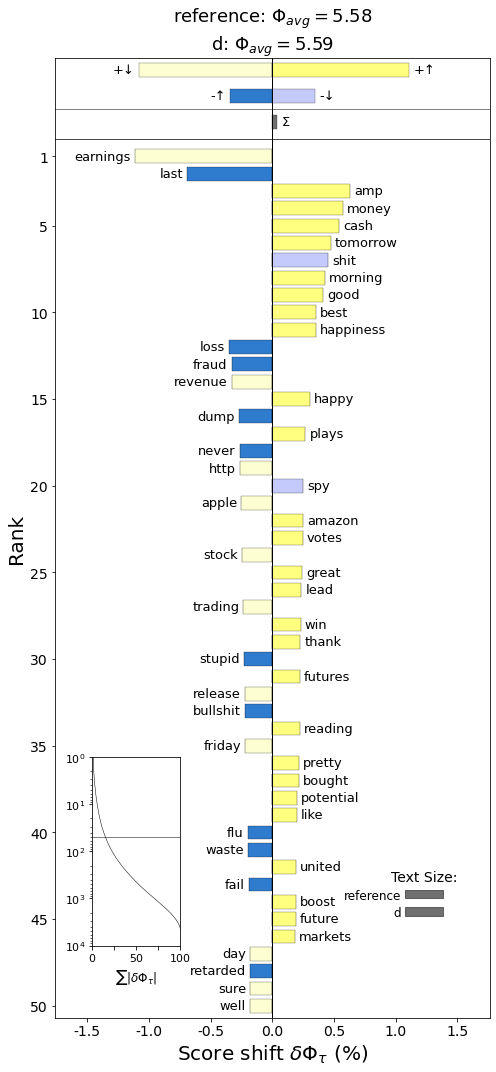

In [17]:
sentiment_shift = sh.WeightedAvgShift(type2freq_1 = p_ref,
                     type2freq_2 = p,
                       type2score_1 = lab_dict,
                   reference_value =5)


sentiment_shift.get_shift_graph(detailed=True,
                               system_names = ["reference","d"])
plt.show()

The figure shows that the chosen date and the reference date have almost the same average reference score. Although the average reference score is similar, there are differences in the word used on the two days. Notably there is an increase in the frequency in which the words 'last', 'loss', 'fraud', 'never', 'stupid', 'bullshit', 'flu', 'waste', 'fail' and 'retarded' is used. All of these words contribute to a negative sentiment score and apart from 'flu' they could be words in which an election could be described. <br>
The increase in frequency of words such as 'win', 'thank', 'votes', 'happy, 'lead' and 'great' could also be used to describe the results from the election given that your political orientation favors Biden and not Trump. 

There is a decrease in relative frequency of positive words like 'earnings' and 'revenue' for instance. Especially 'earnings' sees a large decrease in use between the chosen day and the preceding seven days.

>    9. How do words that you printed in step 6 relate to those shown by the WordShift? 

The words we printed in step 6 were sorted by the measure of sentiment*frequency of words sorted from highest to lowest absolute values. The Wordshift shows the words sorted in the same fashion and the first 10 words in the Wordshift is therefore the same as the words shown in step 6 (except for the words 'best' and 'happiness' which are switched around due to a rounding of the values)